In [279]:
%matplotlib inline  
from IPython.display import clear_output
from math import isnan
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import FloatSlider, BoundedFloatText, Dropdown, Button, BoundedIntText, IntSlider, Button, jslink
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

TYPE_WALL = 'стена'
TYPE_PIPE = 'труба'
TYPE_WINDOW = 'окно'


surface_type_input = Dropdown(
    options=[TYPE_WALL, TYPE_PIPE, TYPE_WINDOW],
    value=TYPE_WALL,
    description='Тип поверхности'
)

TYPE_SONATA = 'Соната-АВ'
TYPE_VNG = 'VNG-012GL'

defence_type_input = Dropdown(
    options=[TYPE_SONATA, TYPE_VNG],
    value=TYPE_SONATA,
    description='Виброакустич. защита'
)

LEVEL_MEDIUM = 'средний'
LEVEL_LOUD = 'громкий'
LEVEL_VERY_LOUD = 'очень громкий'

signal_level_input = Dropdown(
    options=[LEVEL_MEDIUM, LEVEL_LOUD, LEVEL_VERY_LOUD],
    value=LEVEL_MEDIUM,
    description='Уровень скрываемого сигнала'
)


PROFILE_MIN = 'минимальный'
PROFILE_MED = 'средний'
PROFILE_MAX = 'максимальный'

profile_input = Dropdown(
    options=[PROFILE_MIN, PROFILE_MED, PROFILE_MAX],
    value=PROFILE_MED,
    description='Профиль защиты'
)


clarity_input_text = BoundedFloatText(
    description='Слов. разб. речи',
    value=0.38,
    min=0.0,
    max=1.0,
)
clarity_input = FloatSlider(
    min=0.0,
    max=1.0,
    step=0.001,
    value=0.38
)

link = jslink((clarity_input_text, 'value'), (clarity_input, 'value'))


width_input_text = BoundedIntText(
    description='Ширина (в клетках)',
    min=1,
    max=100,
    value=5
)
width_input = IntSlider(
    min=1,
    max=100,
    value=5
)
link = jslink((width_input_text, 'value'), (width_input, 'value'))



height_input_text = BoundedIntText(
    description='Высота (в клетках)',
    min=1,
    max=100,
    value=5
)
height_input = IntSlider(
    min=1,
    max=100,
    value=5
)
link = jslink((height_input_text, 'value'), (height_input, 'value'))


run_btn = Button(description='Запуск')

        

In [280]:
vibes = [
    (1, 2)
]

In [281]:
def color(value, clarity):
    if value <= clarity:
        return 'green'
    elif value <= clarity + 0.1:
        return 'yellow'
    else:
        return 'red'



def render(width, height, vibes, tiles, tile_size=0.1, clarity=0.4): 
    fig1 = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax1 = fig1.add_subplot(111, aspect='equal')
    for p in [

                
            patches.Rectangle(
                    np.multiply(tiles[i]["position"], tile_size) - tile_size,
                    tile_size,
                    tile_size,
                    facecolor=color(tiles[i]['value'], clarity)
                    ) for i in range(len(tiles))
    ]:
        ax1.add_patch(p)
        for vibe in vibes:
            circle = plt.Circle(
                (vibe[0] * tile_size - tile_size / 2, vibe[1] * tile_size - tile_size / 2), 
                tile_size / 3, 
                color='Blue'
            )
            ax1.add_artist(circle)
    plt.axis([0, np.ceil(tile_size * width), 0, np.ceil(tile_size * height)])
            


In [282]:
# Переводим все значения из таблиц А.1-А.8
# исх. данные
# уровень тест сигнала средний
# уровень излучения виброизлучателя максимальный
#датчик-соната АВ тяжелый
# ограждающая конструкция стена



#Значение  формантного параметра речи в полосе DAi, дБ
def DA(i):
    return [25, 18, 14, 9, 6, 5, 4][i - 1]

def k(i):
    return [0.01, 0.03, 0.12, 0.2, 0.3, 0.26, 0.07][i - 1]

#Уровень виброускорения от тестового речевого сигнала (Средняя речь) Vсi, дБ
def Vc(i):
    return [57.5, 57, 57, 52, 42.5, 51.5, 41][i - 1]

#Уровень шума от системы защиты V*, дБ
#(уровень максимальный)
def Vstar(i):
    return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]

def Ln(i):
    return 10 ** (Vstar(i) / 20) * (10 ** (-6))
 
def Lsh1(x):
    val = (0.0004-6*10**(-5)*np.log(x))
    return 1659.587*Ln(1)*val
def Lsh2(x):    
    val = (0.0027-3*10**(-4)*np.log(x))
    return 275.4229*Ln(2)*val
def Lsh3(x):
    val = (0.0054-0.001*np.log(x))
    return 120.2264*Ln(3)*val
def Lsh4(x):     
    val = (0.0074-1*10**(-3)*np.log(x))
    return 98.8553*Ln(4)*val
def Lsh5(x):    
    val = (0.0057-0.001*np.log(x))
    return 113.5011*Ln(5)*val
def Lsh6(x):    
    val = (0.0082-0.002*np.log(x))
    return 74.1310*Ln(6)*val
def Lsh7(x):    
    val = (0.0019 - 6 * (10**(-4)) * np.log(x))
    return 285.1018*Ln(7)*val
    
def Lsh(i, x):
    return [Lsh1, Lsh2, Lsh3, Lsh4, Lsh5, Lsh6, Lsh7][i - 1](x)

def Vsh(i, x): # CORRECT
    #print("Vsh={}, i={}, x={}".format(20 * np.log10(Lsh(i, x)) + 120, i, x))
    return 20 * np.log10(Lsh(i, x)) + 120

def q(i, x):
    return Vc(i) - Vsh(i, x)

def Qi(i, x):
    #print("Qi, i={}, x={}, Qi={}".format(i, x, q(i,x) - DA(i)))
    return q(i, x) - DA(i)

def p(i, x): # ALL CORRECT UNTIL THIS POINT. Motherfucker was here
    Q = Qi(i, x)
    
    val = (
        0.78 + 
        5.46 * 
        np.exp(-4.3 * (10 ** -3) * ((27.3 - np.abs(Q)) ** 2))
    ) / (
        1 + (10 ** (0.1 * np.abs(Q)))
    )
    
    
    if Q <= 0:
        #print("p: i={}, x={}, val={}, Q={}".format(i, x, val, Q))
        return val
    else:
        #print("p: i={}, x={}, val={}, Q={}".format(i, x, 1 - val, Q))
        return 1 - val
    
def Ri(i, x):
    return p(i, x) * k(i)

def W(x):
    R = np.sum(Ri(i + 1, x) for i in range(7))
    if isnan(R):
        print('NAN: {}'.format(x))
    if R < 0.15: 
        return 1.54 * (R ** (0.25)) * (1 - np.exp(-11 * R))
    else: 
        return 1 - np.exp(-(11 * R) / (1 + 0.7 * R))


In [283]:
def f(x, y, vibe, tile_size):
    vx, vy = vibe
    distance = np.sqrt(np.sum(np.square([(x - vx) * tile_size, (y - vy) * tile_size])))
    if distance > 0:
        return W(distance)
    else:
        return 0.0

def generate_tile(x, y, vibes, surface_type, defence_type, signal_level, profile, clarity, tile_size):
    values = np.array([f(x, y, v, tile_size) for v in vibes])
    real_value = np.sqrt(np.sum(np.power(values, 2.0)))

    
    return { "position": (x, y), "value": real_value }

In [284]:
def calculate_everything(b):
    clear_output()
    surface_type = surface_type_input.value
    defence_type = defence_type_input.value
    signal_level = signal_level_input.value
    profile = profile_input.value
    clarity = clarity_input.value
    width = width_input.value
    height = height_input.value
    
    if surface_type == TYPE_WALL:
        tile_size = 1.0
    else:
        tile_size = 0.1
    
    tiles = [
        generate_tile(
            x + 1, 
            y + 1, 
            vibes=vibes,
            surface_type=surface_type,
            defence_type=defence_type,
            signal_level=signal_level,
            profile=profile,
            clarity=clarity,
            tile_size=tile_size
        ) 
        for x in range(width) for y in range(height)
    ]
    
    print(tiles)
    
    render(width, height, vibes, tiles, tile_size=tile_size, clarity=clarity)


run_btn.on_click(calculate_everything)

[{'position': (1, 1), 'value': 0.1346166577480252}, {'position': (1, 2), 'value': 0.0}, {'position': (1, 3), 'value': 0.1346166577480252}, {'position': (1, 4), 'value': 0.18249557492402144}, {'position': (1, 5), 'value': 0.22124542289568128}, {'position': (2, 1), 'value': 0.15617619033511676}, {'position': (2, 2), 'value': 0.1346166577480252}, {'position': (2, 3), 'value': 0.15617619033511676}, {'position': (2, 4), 'value': 0.1921995271815771}, {'position': (2, 5), 'value': 0.22705571816870282}, {'position': (3, 1), 'value': 0.1921995271815771}, {'position': (3, 2), 'value': 0.18249557492402144}, {'position': (3, 3), 'value': 0.1921995271815771}, {'position': (3, 4), 'value': 0.21498147594393713}, {'position': (3, 5), 'value': 0.2424345039293799}, {'position': (4, 1), 'value': 0.22705571816870282}, {'position': (4, 2), 'value': 0.22124542289568128}, {'position': (4, 3), 'value': 0.22705571816870282}, {'position': (4, 4), 'value': 0.2424345039293799}, {'position': (4, 5), 'value': 0.263

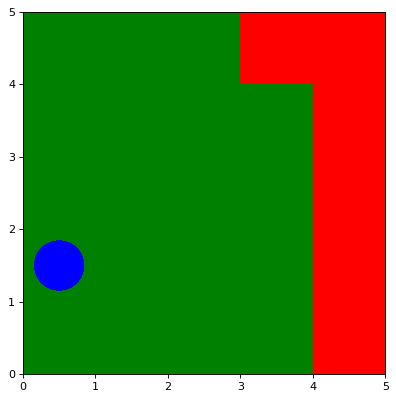

In [285]:


                                    
                                              
display(
    surface_type_input, 
    defence_type_input, 
    signal_level_input,
    profile_input,
    clarity_input_text,
    clarity_input,
    width_input_text, 
    width_input, 
    height_input_text, 
    height_input, 
    run_btn
)
